# Deep Learning Challenge - Training
## Michelle Rohrer

Dieses Notebook enthält alle Trainings.

### Pakete laden

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pydantic')

# Dann der Rest Ihrer Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import wandb
from dotenv import load_dotenv
import pickle

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from src.plots import (
    plot_training_curves,
    plot_hyperparameter_comparison
)
from src.model import BaselineCNN
from src.test_train import (
    train_model,
    hyperparameter_tuning_with_wandb
)
from src.evaluation import (
    cross_validation_training
)

load_dotenv()
wandb_key = os.getenv('KEY')

if wandb_key:
    print("WanDB Key erfolgreich geladen")
else:
    print("WanDB Key nicht gefunden")


WanDB Key erfolgreich geladen


### Daten laden


In [2]:
base_path = "data"
train_dir = os.path.join(base_path, "train")
test_dir  = os.path.join(base_path, "test")

img_size = 48
batch_size = 64

# Transformationen
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# train laden
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform
)

# 80/20 Split für Training/Validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Test-Dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform
)

# DataLoader erstellen
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Klassen: {full_train_dataset.class_to_idx}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Klassen: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Training samples: 22967
Validation samples: 5742
Test samples: 7178


### Training des Basismodells

**Zweck:** Automatisches Tracking aller Experimente für bessere Reproduzierbarkeit und Analyse.

**Was wird getrackt:**
- **Hyperparameter:** Lernrate, Batch-Größe, Optimizer-Einstellungen
- **Metriken:** Training/Validation Loss und Accuracy pro Epoche
- **Test-Metriken:** Accuracy, Precision, Recall, F1-Score, Top-K Accuracy


In [3]:
# wandb Setup
# wandb API Key aus .env laden
wandb_key = os.getenv('KEY')
if wandb_key:
    wandb.login(key=wandb_key)
    print("wandb erfolgreich authentifiziert")
else:
    print("wandb API Key nicht in .env gefunden")

# Device Setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Verwende Device: {device}")

# Klassennamen für Evaluation
class_names = list(full_train_dataset.class_to_idx.keys())
num_classes = len(full_train_dataset.class_to_idx)
print(f"Klassen: {class_names}")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\MichelleRohrer\_netrc
wandb: Currently logged in as: michelle-rohrer (michelle-rohrer-fhnw) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb erfolgreich authentifiziert
Verwende Device: cpu
Klassen: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


=== Training des Basismodells ===
Konfiguration: SGD (momentum=0), LR=0.01, Batch=64, 200 Epochen


Training startet: 200 Epochen, LR=0.01, Batch=64
Early Stopping: patience=20, min_delta=0.001
------------------------------------------------------------
Epoch   1/200 | Train Loss: 1.8526 | Val Loss: 1.8091 | Train Acc: 23.88% | Val Acc: 25.06% | Patience: 0/20
Epoch   5/200 | Train Loss: 1.8056 | Val Loss: 1.7963 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/20
Epoch  10/200 | Train Loss: 1.7598 | Val Loss: 1.7521 | Train Acc: 27.40% | Val Acc: 27.19% | Patience: 0/20
Epoch  15/200 | Train Loss: 1.6844 | Val Loss: 1.6630 | Train Acc: 33.61% | Val Acc: 35.28% | Patience: 0/20
Epoch  20/200 | Train Loss: 1.6133 | Val Loss: 1.6086 | Train Acc: 37.72% | Val Acc: 36.82% | Patience: 0/20
Epoch  25/200 | Train Loss: 1.5559 | Val Loss: 1.5809 | Train Acc: 40.08% | Val Acc: 38.14% | Patience: 0/20
Epoch  30/200 | Train Loss: 1.5000 | Val Loss: 1.5160 | Train Acc: 42.33% | Val Acc: 40.91% | Patience: 0/20
Epoch  35/200 | Train Loss: 1.4414 | Val Loss: 1.4769 | Train Acc: 45.01% | Val Ac

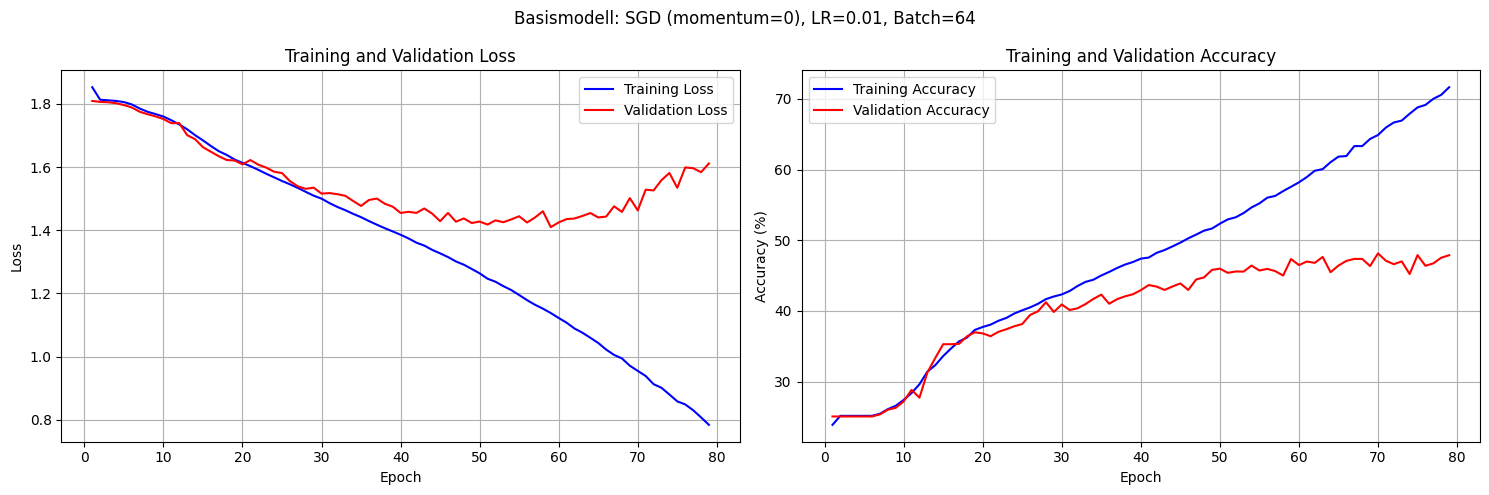

Basismodell gespeichert als 'models/baseline_model.pth'


In [ ]:
# Basismodell erstellen und trainieren
print("=== Training des Basismodells ===")
print("Konfiguration: SGD (momentum=0), LR=0.01, Batch=64, 200 Epochen")

# Modell initialisieren
model = BaselineCNN(img_size=img_size, num_classes=num_classes).to(device)

# Training durchführen mit wandb
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=200,
    learning_rate=0.01,
    batch_size=64,
    use_wandb=True,
    run_name="baseline_model",
    early_stopping=True,
    patience=20,
    min_delta=0.001
)

# Modell speichern
torch.save(model.state_dict(), 'models/baseline_model.pth')
print("Basismodell gespeichert als 'models/baseline_model.pth'")


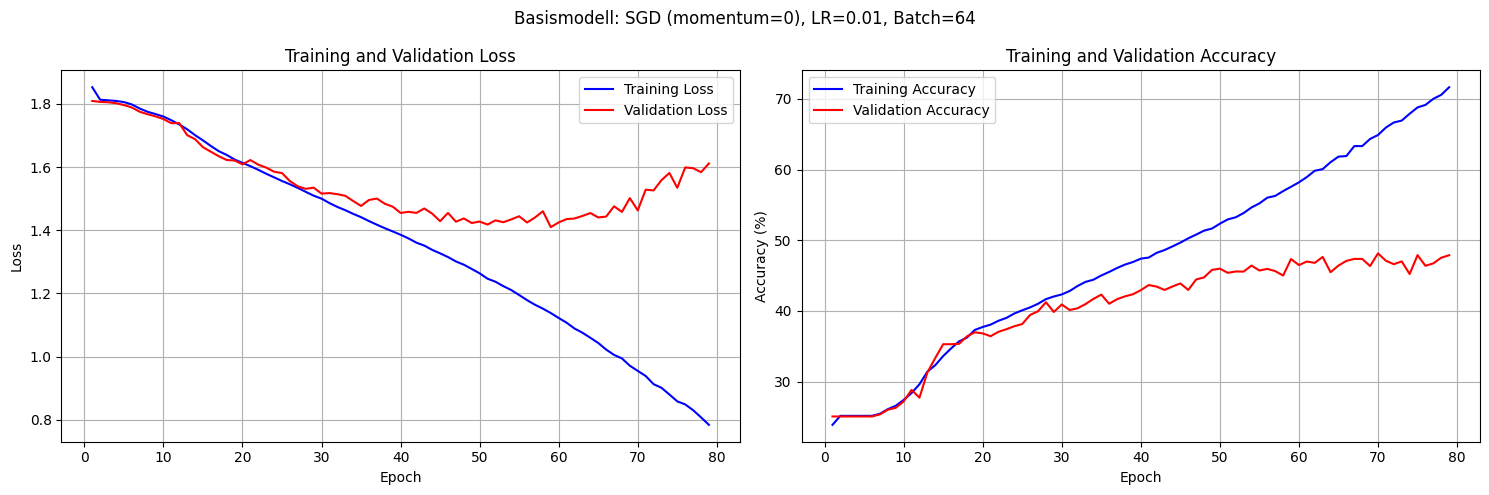

In [6]:
# Lernkurven plotten und speichern
fig = plot_training_curves(train_losses, val_losses, train_accs, val_accs, 
                          title="Basismodell: SGD (momentum=0), LR=0.01, Batch=64")

# Plot als Bild speichern
fig.savefig('plots/baseline_training_curves.png', dpi=300, bbox_inches='tight')

### Hyperparameter-Tuning

**Ziel:** Vergleich verschiedener Lernraten und Batch-Größen anhand der Lernkurven und Metriken.

**Testkonfigurationen:**
- **Lernraten:** [0.001, 0.01, 0.1]
- **Batch-Größen:** [32, 64, 128]
- **Epochen:** 50 (für schnelleren Vergleich)
- **Optimizer:** SGD ohne Momentum


In [ ]:
# Hyperparameter-Tuning mit wandb Integration
print("=== Hyperparameter-Tuning ===")

# Testkonfigurationen
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64] 
num_epochs = 50  # Weniger Epochen für schnellere Tests

# Hyperparameter-Tuning mit wandb durchführen
results = hyperparameter_tuning_with_wandb(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    num_epochs=num_epochs
)


=== Hyperparameter-Tuning mit wandb ===
=== Hyperparameter-Tuning mit wandb ===
Teste 3 Lernraten × 3 Batch-Größen = 9 Konfigurationen

--- LR_0.001_Batch_16 ---


Training startet: 50 Epochen, LR=0.001, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.9041 | Val Loss: 1.8642 | Train Acc: 21.97% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.8120 | Val Loss: 1.8059 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  10/50 | Train Loss: 1.8062 | Val Loss: 1.7996 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.7855 | Val Loss: 1.7782 | Train Acc: 25.28% | Val Acc: 25.15% | Patience: 0/8
Epoch  20/50 | Train Loss: 1.7567 | Val Loss: 1.7497 | Train Acc: 28.19% | Val Acc: 27.92% | Patience: 0/8
Epoch  25/50 | Train Loss: 1.7286 | Val Loss: 1.7218 | Train Acc: 30.40% | Val Acc: 30.60% | Patience: 0/8
Epoch  30/50 | Train Loss: 1.6960 | Val Loss: 1.6831 | Train Acc: 32.91% | Val Acc: 33.72% | Patience: 0/8
Epoch  35/50 | Train Loss: 1.6576 | Val Loss: 1.6673 | Train Acc: 35.08% | Val Acc: 33.61% | Pati

Finale Validation Accuracy: 39.17%
Finale Validation Loss: 1.5681

--- LR_0.001_Batch_32 ---


Training startet: 50 Epochen, LR=0.001, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.9113 | Val Loss: 1.8596 | Train Acc: 19.40% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.8132 | Val Loss: 1.8069 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  10/50 | Train Loss: 1.8116 | Val Loss: 1.8054 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 4/8
Epoch  15/50 | Train Loss: 1.8098 | Val Loss: 1.8036 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  20/50 | Train Loss: 1.8069 | Val Loss: 1.8009 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  25/50 | Train Loss: 1.8004 | Val Loss: 1.7943 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  30/50 | Train Loss: 1.7857 | Val Loss: 1.7812 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  35/50 | Train Loss: 1.7729 | Val Loss: 1.7706 | Train Acc: 26.17% | Val Acc: 25.50% | Pati

Finale Validation Accuracy: 28.68%
Finale Validation Loss: 1.7367

--- LR_0.001_Batch_64 ---


Training startet: 50 Epochen, LR=0.001, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.9499 | Val Loss: 1.9386 | Train Acc: 12.39% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.8601 | Val Loss: 1.8455 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.8143 | Val Loss: 1.8081 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.8125 | Val Loss: 1.8063 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 3/8
Epoch  20/50 | Train Loss: 1.8118 | Val Loss: 1.8057 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 1/8
Epoch  25/50 | Train Loss: 1.8111 | Val Loss: 1.8050 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 6/8
Epoch  30/50 | Train Loss: 1.8102 | Val Loss: 1.8043 | Train Acc: 25.15% | Val Acc: 25.06% | Patience: 3/8
Epoch  35/50 | Train Loss: 1.8091 | Val Loss: 1.8034 | Train Acc: 25.15% | Val Acc: 25.06% | Pati

Finale Validation Accuracy: 25.06%
Finale Validation Loss: 1.7973

--- LR_0.01_Batch_16 ---


Training startet: 50 Epochen, LR=0.01, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8258 | Val Loss: 1.8056 | Train Acc: 24.81% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.6947 | Val Loss: 1.6672 | Train Acc: 32.42% | Val Acc: 34.62% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.4823 | Val Loss: 1.4673 | Train Acc: 43.00% | Val Acc: 43.61% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.3076 | Val Loss: 1.4022 | Train Acc: 49.92% | Val Acc: 46.74% | Patience: 2/8
Epoch  20/50 | Train Loss: 1.1150 | Val Loss: 1.3466 | Train Acc: 57.94% | Val Acc: 49.37% | Patience: 3/8
Epoch  25/50 | Train Loss: 0.8899 | Val Loss: 1.3651 | Train Acc: 67.61% | Val Acc: 51.06% | Patience: 3/8
Epoch  30/50 | Train Loss: 0.6379 | Val Loss: 1.7124 | Train Acc: 76.68% | Val Acc: 50.12% | Patience: 8/8

Early Stopping nach 30 Epochen!
Beste Validation Loss: 1.3224 in Epoche 22


Finale Validation Accuracy: 50.12%
Finale Validation Loss: 1.7124

--- LR_0.01_Batch_32 ---


Training startet: 50 Epochen, LR=0.01, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8313 | Val Loss: 1.8069 | Train Acc: 24.95% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.7493 | Val Loss: 1.7312 | Train Acc: 28.50% | Val Acc: 29.33% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.6054 | Val Loss: 1.5906 | Train Acc: 37.64% | Val Acc: 38.35% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.4933 | Val Loss: 1.5202 | Train Acc: 42.50% | Val Acc: 40.93% | Patience: 0/8
Epoch  20/50 | Train Loss: 1.3853 | Val Loss: 1.4356 | Train Acc: 47.05% | Val Acc: 44.65% | Patience: 0/8
Epoch  25/50 | Train Loss: 1.2751 | Val Loss: 1.3990 | Train Acc: 51.55% | Val Acc: 45.86% | Patience: 0/8
Epoch  30/50 | Train Loss: 1.1491 | Val Loss: 1.3899 | Train Acc: 56.79% | Val Acc: 47.72% | Patience: 1/8
Epoch  35/50 | Train Loss: 1.0116 | Val Loss: 1.3907 | Train Acc: 62.69% | Val Acc: 48.75% | Patie

Finale Validation Accuracy: 48.26%
Finale Validation Loss: 1.4522

--- LR_0.01_Batch_64 ---


Training startet: 50 Epochen, LR=0.01, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8529 | Val Loss: 1.8097 | Train Acc: 23.85% | Val Acc: 25.06% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.7863 | Val Loss: 1.7770 | Train Acc: 25.29% | Val Acc: 25.34% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.7281 | Val Loss: 1.7103 | Train Acc: 30.47% | Val Acc: 30.29% | Patience: 0/8
Epoch  15/50 | Train Loss: 1.6403 | Val Loss: 1.6343 | Train Acc: 36.09% | Val Acc: 36.07% | Patience: 0/8
Epoch  20/50 | Train Loss: 1.5714 | Val Loss: 1.5732 | Train Acc: 39.32% | Val Acc: 38.26% | Patience: 0/8
Epoch  25/50 | Train Loss: 1.5104 | Val Loss: 1.5309 | Train Acc: 41.67% | Val Acc: 40.20% | Patience: 1/8
Epoch  30/50 | Train Loss: 1.4490 | Val Loss: 1.4775 | Train Acc: 44.42% | Val Acc: 42.63% | Patience: 0/8
Epoch  35/50 | Train Loss: 1.3864 | Val Loss: 1.4311 | Train Acc: 47.14% | Val Acc: 44.86% | Patie

Finale Validation Accuracy: 47.65%
Finale Validation Loss: 1.3996

--- LR_0.1_Batch_16 ---


Training startet: 50 Epochen, LR=0.1, Batch=16
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.7691 | Val Loss: 1.6906 | Train Acc: 27.40% | Val Acc: 31.10% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.2724 | Val Loss: 1.3413 | Train Acc: 51.16% | Val Acc: 49.04% | Patience: 0/8
Epoch  10/50 | Train Loss: 0.9361 | Val Loss: 1.5331 | Train Acc: 64.74% | Val Acc: 48.76% | Patience: 4/8

Early Stopping nach 14 Epochen!
Beste Validation Loss: 1.3223 in Epoche 6


Finale Validation Accuracy: 43.07%
Finale Validation Loss: 1.8817

--- LR_0.1_Batch_32 ---


Training startet: 50 Epochen, LR=0.1, Batch=32
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.7978 | Val Loss: 1.7578 | Train Acc: 25.78% | Val Acc: 27.10% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.3336 | Val Loss: 1.3455 | Train Acc: 48.82% | Val Acc: 48.50% | Patience: 0/8
Epoch  10/50 | Train Loss: 0.9346 | Val Loss: 1.3408 | Train Acc: 65.14% | Val Acc: 51.81% | Patience: 2/8
Epoch  15/50 | Train Loss: 0.5609 | Val Loss: 1.8444 | Train Acc: 79.74% | Val Acc: 48.55% | Patience: 7/8

Early Stopping nach 16 Epochen!
Beste Validation Loss: 1.3048 in Epoche 8


Finale Validation Accuracy: 49.11%
Finale Validation Loss: 1.8735

--- LR_0.1_Batch_64 ---


Training startet: 50 Epochen, LR=0.1, Batch=64
Early Stopping: patience=8, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8003 | Val Loss: 1.7639 | Train Acc: 25.33% | Val Acc: 27.71% | Patience: 0/8
Epoch   5/50 | Train Loss: 1.4694 | Val Loss: 1.4403 | Train Acc: 43.15% | Val Acc: 43.59% | Patience: 0/8
Epoch  10/50 | Train Loss: 1.1720 | Val Loss: 1.3578 | Train Acc: 55.69% | Val Acc: 48.14% | Patience: 2/8
Epoch  15/50 | Train Loss: 0.8589 | Val Loss: 1.4413 | Train Acc: 68.22% | Val Acc: 50.49% | Patience: 3/8
Epoch  20/50 | Train Loss: 0.5138 | Val Loss: 1.8800 | Train Acc: 81.14% | Val Acc: 51.38% | Patience: 8/8

Early Stopping nach 20 Epochen!
Beste Validation Loss: 1.3169 in Epoche 12


Finale Validation Accuracy: 51.38%
Finale Validation Loss: 1.8800

=== Hyperparameter-Tuning abgeschlossen ===
Alle Experimente wurden in wandb gespeichert!


In [ ]:
# Visualisierung der Hyperparameter-Ergebnisse
print("=== Hyperparameter-Vergleich ===")

# Zusammenfassung der Ergebnisse
summary_data = []
for config_key, result in results.items():
    summary_data.append({
        'Learning Rate': result['learning_rate'],
        'Batch Size': result['batch_size'],
        'Final Train Acc (%)': result['final_train_acc'],
        'Final Val Acc (%)': result['final_val_acc'],
        'Final Train Loss': result['final_train_loss'],
        'Final Val Loss': result['final_val_loss']
    })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('Final Val Acc (%)', ascending=False)

print("Ergebnisse sortiert nach Validation Accuracy:")
print(df_summary.to_string(index=False))

# Beste Konfiguration finden
best_config = df_summary.iloc[0]
print(f"\nBeste Konfiguration:")
print(f"Learning Rate: {best_config['Learning Rate']}")
print(f"Batch Size: {best_config['Batch Size']}")
print(f"Validation Accuracy: {best_config['Final Val Acc (%)']:.2f}%")


=== Hyperparameter-Vergleich ===
Ergebnisse sortiert nach Validation Accuracy:
 Learning Rate  Batch Size  Final Train Acc (%)  Final Val Acc (%)  Final Train Loss  Final Val Loss
         0.100          64            81.142509          51.375827          0.513771        1.880038
         0.010          16            76.683938          50.121909          0.637864        1.712376
         0.100          32            81.834806          49.111808          0.509277        1.873528
         0.010          32            64.880045          48.258447          0.953613        1.452223
         0.010          64            56.032568          47.648903          1.176764        1.399568
         0.100          16            72.913310          43.068617          0.740427        1.881738
         0.001          16            39.804938          39.167537          1.568298        1.568062
         0.001          32            29.342100          28.683386          1.739914        1.736720
         0.0

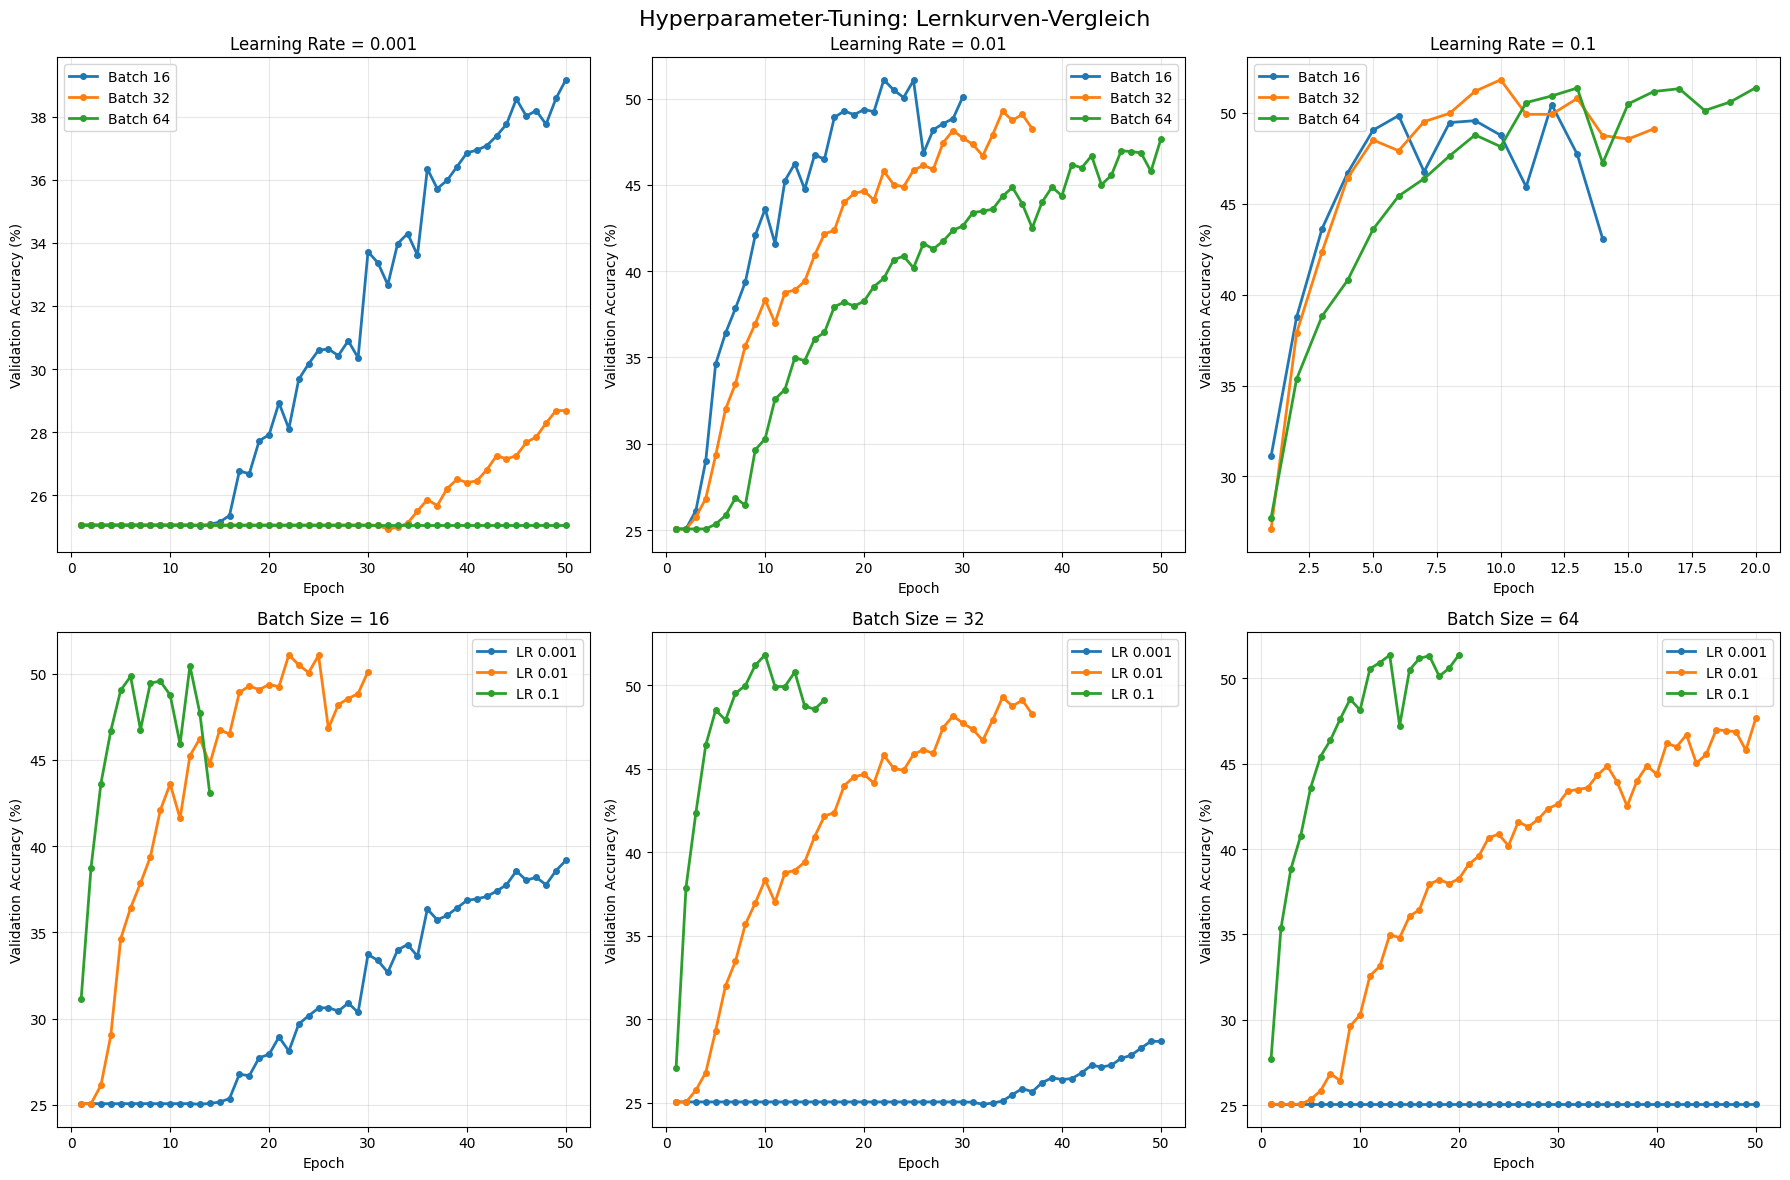

In [ ]:
# Lernkurven-Vergleich für verschiedene Konfigurationen
fig = plot_hyperparameter_comparison(
    results=results,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes,
    save_path='plots/hyperparameter_comparison.png'
)


### Cross-Validation für statistische Fehlerschätzung

**Ziel:** Schätzung des statistischen Fehlers der Metriken durch Cross-Validation.

**Konfiguration:**
- **5-Fold Cross-Validation** auf dem Trainingsdatensatz
- **Beste Hyperparameter** aus dem Tuning verwenden
- **Statistische Auswertung:** Mittelwert ± Standardabweichung


=== Cross-Validation ===
Verwende beste Konfiguration: LR=0.1, Batch=64
Cross-Validation mit 5 Folds

Fold 1/5
------------------------------
Training startet: 50 Epochen, LR=0.1, Batch=64
Early Stopping: patience=10, min_delta=0.001
------------------------------------------------------------
Epoch   1/50 | Train Loss: 1.8169 | Val Loss: 1.7949 | Train Acc: 24.85% | Val Acc: 25.46% | Patience: 0/10
Epoch   5/50 | Train Loss: 1.5335 | Val Loss: 1.4931 | Train Acc: 40.44% | Val Acc: 42.08% | Patience: 0/10
Epoch  10/50 | Train Loss: 1.2365 | Val Loss: 1.3387 | Train Acc: 53.21% | Val Acc: 48.94% | Patience: 0/10
Epoch  15/50 | Train Loss: 0.9337 | Val Loss: 1.4369 | Train Acc: 65.50% | Val Acc: 49.23% | Patience: 2/10
Epoch  20/50 | Train Loss: 0.5928 | Val Loss: 1.8138 | Train Acc: 78.51% | Val Acc: 48.50% | Patience: 7/10

Early Stopping nach 23 Epochen!
Beste Validation Loss: 1.3099 in Epoche 13

Fold 2/5
------------------------------
Training startet: 50 Epochen, LR=0.1, Batch=64
E

C:\Users\MichelleRohrer\AppData\Local\Temp\ipykernel_21424\121460383.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(acc_data, labels=['Training', 'Validation'])
C:\Users\MichelleRohrer\AppData\Local\Temp\ipykernel_21424\121460383.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(loss_data, labels=['Training', 'Validation'])


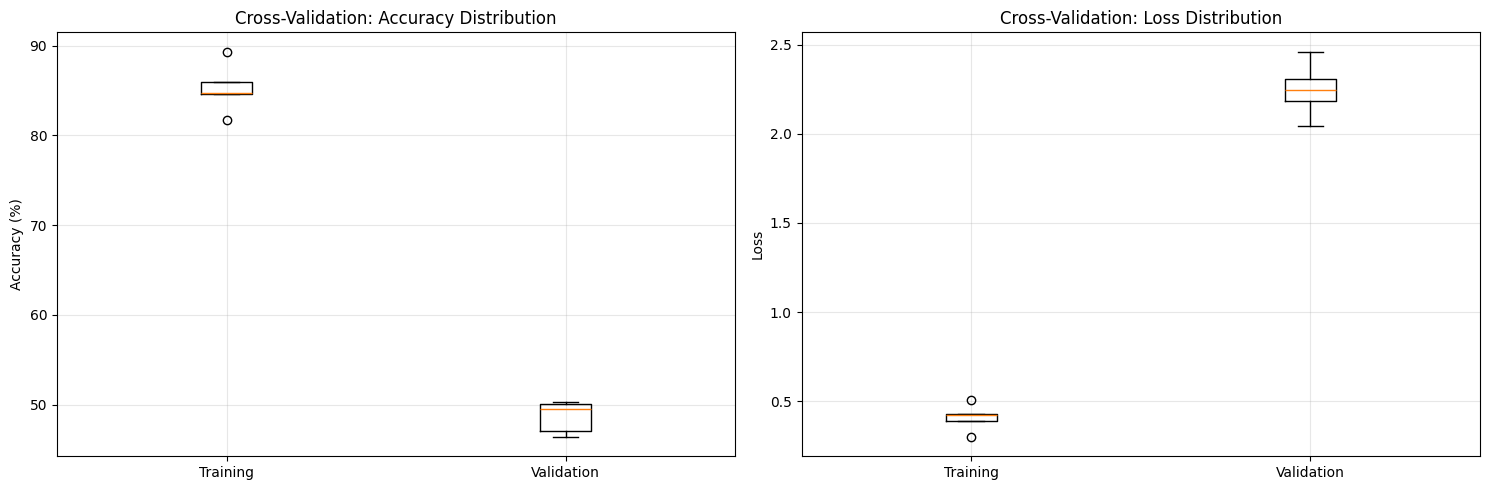

Cross-Validation Ergebnisse gespeichert als 'results/cross_validation_results.json'


In [ ]:
# Cross-Validation für statistische Fehlerschätzung
print("=== Cross-Validation ===")

# Beste Hyperparameter aus dem Tuning verwenden
best_lr = best_config['Learning Rate']
best_batch = int(best_config['Batch Size'])

print(f"Verwende beste Konfiguration: LR={best_lr}, Batch={best_batch}")

# Cross-Validation durchführen
cv_results = cross_validation_training(
    train_dataset=full_train_dataset,
    num_folds=5,
    num_epochs=50, 
    learning_rate=best_lr,
    batch_size=best_batch
)

print(f"\n=== Cross-Validation Ergebnisse ===")
print(f"Training Accuracy: {cv_results['train_accuracies']['mean']:.4f} ± {cv_results['train_accuracies']['std']:.4f}")
print(f"Validation Accuracy: {cv_results['val_accuracies']['mean']:.4f} ± {cv_results['val_accuracies']['std']:.4f}")
print(f"Training Loss: {cv_results['train_losses']['mean']:.4f} ± {cv_results['train_losses']['std']:.4f}")
print(f"Validation Loss: {cv_results['val_losses']['mean']:.4f} ± {cv_results['val_losses']['std']:.4f}")


# Sicherstellen, dass das results Verzeichnis existiert
os.makedirs('results', exist_ok=True)

with open('results/cross_validation_results.json', 'w') as f:
    json.dump({
        'best_hyperparameters': {
            'learning_rate': best_lr,
            'batch_size': best_batch
        },
        'cv_results': cv_results
    }, f, indent=2)

print("Cross-Validation Ergebnisse gespeichert als 'results/cross_validation_results.json'")
